In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Activation,Concatenate,Dropout,BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:
def define_discriminator(image_shape):
    
    # weight initialization
    init = RandomNormal(stddev=0.02) #As described in the original paper

    # source image input
    in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
    # target image input
    in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 

    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
   
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.

    opt = Adam(learning_rate=0.0003, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [ ]:
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 12)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
    out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
    # define model
    model = Model(in_image, out_image)
    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.

    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator 
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
    return model

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y


In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))


In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    d1=[]
    d2=[]
    g=[]
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real) # Model([in_src_image, in_target_image], patch_out)
        d1.append(d_loss1)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)  # Model([in_src_image, in_target_image], patch_out)
        d2.append(d_loss2)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB]) # Model(in_src, [dis_out, gen_out])
        g.append(g_loss)
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 3) == 0:
            summarize_performance(i, g_model, dataset)
    steps = np.arange(1,n_steps+1)
    return steps,d1,d2,g
            
    

In [ ]:
import numpy as np 
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re

In [ ]:
IMG_SIZE=256

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def create_dataset():
    photos = []
    photos_labels = []

    files_list1 = sorted(os.listdir("/content/drive/MyDrive/dataset/CUHK_training_cropped_photos/photos"))
    for file_name in sorted(files_list1):
        path=("/content/drive/MyDrive/dataset/CUHK_training_cropped_photos/photos"+"/" +file_name)
        img=cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image=cv2.resize(img,(IMG_SIZE,IMG_SIZE))  
       
        photos.append(np.array(image))  
        photos_labels.append(file_name)
    
    files_list2 = sorted( os.listdir("/content/drive/MyDrive/dataset/CUHK_testing_cropped_photos/photos"))
    for file_name in sorted(files_list2):
        path=("/content/drive/MyDrive/dataset/CUHK_testing_cropped_photos/photos"+"/" +file_name)
        img=cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image=cv2.resize(img,(IMG_SIZE,IMG_SIZE))  
        photos.append(np.array(image))  
        photos_labels.append(file_name)
                            
    sketches= []  
    sketches_labels = []

    files_list3 =sorted( os.listdir("/content/drive/MyDrive/dataset/CUHK_training_cropped_sketches/sketches"))
    for file_name in sorted(files_list3):
        path=("/content/drive/MyDrive/dataset/CUHK_training_cropped_sketches/sketches"+"/" +file_name)
        img=cv2.imread(path)
     
        image2=cv2.resize(img,(IMG_SIZE,IMG_SIZE))  
        sketches.append(np.array(image2))  
        sketches_labels.append(file_name)
        
    files_list4 =sorted( os.listdir("/content/drive/MyDrive/dataset/CUHK_testing_cropped_sketches/sketches"))
    for file_name in sorted(files_list4):
        path=("/content/drive/MyDrive/dataset/CUHK_testing_cropped_sketches/sketches"+"/" +file_name)
        img=cv2.imread(path)

        image2=cv2.resize(img,(IMG_SIZE,IMG_SIZE))  
        sketches.append(np.array(image2))  
        sketches_labels.append(file_name)
    sketches = np.asarray(sketches)
    photos = np.asarray(photos)
    sketches_labels = np.array(sketches_labels)
    
    return photos,sketches,sketches_labels, photos_labels

In [ ]:
photos,sketches, sketches_labels,photos_labels=create_dataset()


In [ ]:
photo=photos[:100]
sketches=sketches[:100]

In [ ]:
print(photos.shape)
print(sketches.shape)

(188, 256, 256, 3)
(100, 256, 256, 3)


In [ ]:
def visual(index):
    plt.subplot(1, 2, 1)
    plt.imshow(photos[index])
    
    plt.xlabel(photos_labels[index])

    plt.subplot(1, 2, 2)
    plt.imshow(sketches[index])
    plt.xlabel(sketches_labels[index])

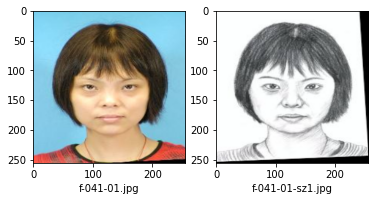

In [ ]:
visual(90)

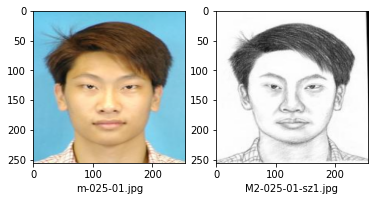

In [ ]:
visual(50)

In [ ]:
# define input shape based on the loaded dataset
image_shape = sketches.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)



In [ ]:
def preprocess_data(data):
    # load compressed arrays
    # unpack arrays
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


In [ ]:
# load and prepare training images
data = [sketches, photos]
dataset = preprocess_data(data)

In [ ]:
from datetime import datetime 
start1 = datetime.now() 

steps,d_loss1,d_loss2,g_loss=train(d_model, g_model, gan_model, dataset, n_epochs=3, n_batch=1) 
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

In [ ]:
f = plt.figure()
f.set_figwidth(15)
plt.plot(steps, d_loss1, 'red', label = 'd_loss1')


In [ ]:
f = plt.figure()
f.set_figwidth(15)
plt.plot(steps, d_loss2, 'red', label = 'd_loss2')

In [ ]:
f = plt.figure()
f.set_figwidth(15)
plt.plot(steps, g_loss, 'red', label = 'g_loss')

In [ ]:
photos,sketches,sketches_labels, photos_labels=create_dataset()

In [ ]:
X_test=photos[100:]

y_test=sketches[100:]

In [ ]:
y_test.shape

In [ ]:
plt.imshow(X_test[10])

In [ ]:
data = [y_test,X_test]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [ ]:
gen_photos=[]
   
     
        

[X1, X2] = dataset
# select random example
for i in range(0,88):
  
    src_image, tar_image = X1[[i]], X2[[i]]
    # generate image from source

    gen_image = g_model.predict(src_image)
    
    gen_photos.append(np.array(gen_image))
# plot all three images
gen_photos=np.array(gen_photos)

In [ ]:
gen_photos.shape

In [ ]:
gen_photos.resize(88,  256, 256, 3)

In [ ]:
plt.imshow(X1 [50])

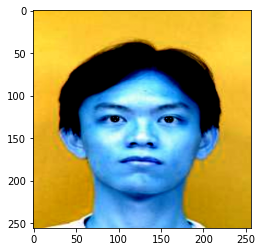

In [ ]:
plt.imshow(X2 [50])

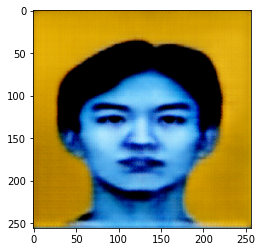

In [ ]:
plt.imshow(gen_photos [50])

In [ ]:
def visualize(index):
    plt.subplot(1, 3, 1)
    img = cv2.cvtColor(X_test[index], cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xlabel(photos_labels[index])
    
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[index])
    plt.xlabel(sketches_labels[index])

    plt.subplot(1, 3, 3)
    img=gen_photos[index]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=(img+1)/2.0
    plt.imshow(img)

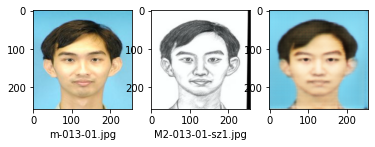

In [ ]:
visualize(39)

In [ ]:
gen_photos.shape

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [ ]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

In [ ]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load cifar10 images
images1=X2
images2 =gen_photos

print('Loaded', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

Loaded (88, 256, 256, 3) (88, 256, 256, 3)
Scaled (88, 299, 299, 3) (88, 299, 299, 3)
3/3 [==============================] - 18s 6s/step
FID: 13.208


In [ ]:
from skimage import metrics
from skimage import measure
import skimage


In [ ]:
mean=0
psnr=0
rmse=0
for i in range(len(gen_photos)):
  ref_img = X2 [i]
  img = gen_photos [i]
  mse_skimg = metrics.mean_squared_error(ref_img, img)
  psnr_skimg =metrics.peak_signal_noise_ratio(ref_img, img, data_range=None)
  rmse_skimg =metrics.normalized_root_mse(ref_img, img)
  mean+=mse_skimg
  psnr+=psnr_skimg
  rmse+=rmse_skimg
mean =mean/len(gen_photos)
rmse= rmse/len(gen_photos)
psnr=psnr/len(gen_photos)
len(gen_photos)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


88

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim 
s=0
for i in range(len(gen_photos)):
  s+= ssim(X2[i].astype(float),gen_photos[i].astype(float), multichannel = True)

s=s/len(gen_photos)
print(s)

0.4524178643475052


In [ ]:
print(mean)

0.12393677579821674


In [ ]:
print(psnr)

In [ ]:
print(rmse)

In [ ]:
'''lr=0.0003,beta=0.6
fid=11.7
lr=0.0003,beta=0.3
fid=11.1
lr=0.0003,beta=0.5
fid=8.6
lr=0.0002,beta=0.5
fid=8.7'''